In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor 
import sqlite3
import math

In [2]:
# Read in the data from the database
conn = sqlite3.connect('C:\\Users\\xz\\Desktop\\1DConv\\24W-PIC16B-Group4\\data\\tables.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())
# Extract two tables from it and store them in two pd df
ds = pd.read_sql_query("SELECT * from df_2023_h1_feature", conn)
target = pd.read_sql_query("SELECT * from df_2023_h1_target", conn)

[('df_2023_h1_feature',), ('df_2023_h1_target',)]


In [3]:
ds_new = ds.copy()
ds

,[QUOTE_UNIXTIME],[EXPIRE_UNIX],[STRIKE],[UNDERLYING_LAST],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],...,[C_ASK],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[P_BID],[P_ASK]
0,-1.69160,-1.531564,-1.054517,-2.406592,1.054125,-0.052714,0.000146,-0.391189,-0.307878,11.711458,...,0.676304,1.120791,-0.013192,0.001135,0.086874,0.592295,3.380989,-0.100406,-0.563368,-0.566211
1,-1.69160,-1.531564,-0.936052,-2.406592,1.041020,0.036229,0.000190,-0.390353,-0.308470,10.342762,...,0.479078,1.120350,-0.013031,0.001152,0.086843,0.592878,2.599981,-0.100406,-0.563368,-0.566211
2,-1.69160,-1.531564,-0.888665,-2.406592,1.035470,0.083539,0.000199,-0.393217,-0.308536,9.795964,...,0.400187,1.119196,-0.013111,0.001152,0.086442,0.592606,2.292638,-0.100406,-0.563368,-0.566211
3,-1.69160,-1.531564,-0.876819,-2.406592,1.048893,0.103725,0.000140,0.031159,-0.308217,9.553426,...,0.389734,1.120644,-0.013015,0.001157,0.086741,0.591011,2.214716,-0.100406,-0.563368,-0.566211
4,-1.69160,-1.531564,-0.864972,-2.406592,1.030873,0.108141,0.000225,-0.438792,-0.308574,9.529689,...,0.371195,1.119712,-0.013079,0.001120,0.086482,0.591167,2.139460,-0.100406,-0.563368,-0.566211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331604,1.78216,1.881977,0.367073,1.410238,-0.175447,0.125803,0.058474,0.064804,0.473889,-0.825637,...,-0.386156,-0.261286,0.003340,0.057390,0.064104,-2.657456,-0.483741,-0.100406,-0.191656,-0.130110
331605,1.78216,1.881977,0.426306,1.410238,-0.288188,0.141573,0.057498,0.121952,0.401497,-0.825637,...,-0.472936,-0.405104,0.004291,0.054827,0.067442,-2.681954,-0.504299,-0.100406,-0.142171,-0.085819
331606,1.78216,1.881977,0.485538,1.410238,-0.406236,0.147881,0.055627,0.179100,0.323910,-0.825637,...,-0.521651,-0.565709,0.005225,0.050409,0.071071,-2.573385,-0.528800,-0.100406,-0.090211,-0.033009
331607,1.78216,1.881977,0.544771,1.410238,-0.524528,0.142835,0.052804,0.249133,0.243663,-0.825637,...,-0.564252,-0.714509,0.005499,0.044680,0.074684,-2.371958,-0.536906,-0.100406,-0.024928,0.033049


In [4]:
# UMMM, we first standardize two cols 
from sklearn.preprocessing import StandardScaler
import warnings
with warnings.catch_warnings():
# ignore all caught warnings
    warnings.filterwarnings("ignore")
    scaler = StandardScaler()
    tbd = ['[QUOTE_UNIXTIME]', '[EXPIRE_UNIX]']
    ds_new[tbd] = scaler.fit_transform(ds[tbd])

In [5]:
torch.cuda.is_available()

True

In [6]:
ds

,[QUOTE_UNIXTIME],[EXPIRE_UNIX],[STRIKE],[UNDERLYING_LAST],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],...,[C_ASK],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[P_BID],[P_ASK]
0,-1.69160,-1.531564,-1.054517,-2.406592,1.054125,-0.052714,0.000146,-0.391189,-0.307878,11.711458,...,0.676304,1.120791,-0.013192,0.001135,0.086874,0.592295,3.380989,-0.100406,-0.563368,-0.566211
1,-1.69160,-1.531564,-0.936052,-2.406592,1.041020,0.036229,0.000190,-0.390353,-0.308470,10.342762,...,0.479078,1.120350,-0.013031,0.001152,0.086843,0.592878,2.599981,-0.100406,-0.563368,-0.566211
2,-1.69160,-1.531564,-0.888665,-2.406592,1.035470,0.083539,0.000199,-0.393217,-0.308536,9.795964,...,0.400187,1.119196,-0.013111,0.001152,0.086442,0.592606,2.292638,-0.100406,-0.563368,-0.566211
3,-1.69160,-1.531564,-0.876819,-2.406592,1.048893,0.103725,0.000140,0.031159,-0.308217,9.553426,...,0.389734,1.120644,-0.013015,0.001157,0.086741,0.591011,2.214716,-0.100406,-0.563368,-0.566211
4,-1.69160,-1.531564,-0.864972,-2.406592,1.030873,0.108141,0.000225,-0.438792,-0.308574,9.529689,...,0.371195,1.119712,-0.013079,0.001120,0.086482,0.591167,2.139460,-0.100406,-0.563368,-0.566211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331604,1.78216,1.881977,0.367073,1.410238,-0.175447,0.125803,0.058474,0.064804,0.473889,-0.825637,...,-0.386156,-0.261286,0.003340,0.057390,0.064104,-2.657456,-0.483741,-0.100406,-0.191656,-0.130110
331605,1.78216,1.881977,0.426306,1.410238,-0.288188,0.141573,0.057498,0.121952,0.401497,-0.825637,...,-0.472936,-0.405104,0.004291,0.054827,0.067442,-2.681954,-0.504299,-0.100406,-0.142171,-0.085819
331606,1.78216,1.881977,0.485538,1.410238,-0.406236,0.147881,0.055627,0.179100,0.323910,-0.825637,...,-0.521651,-0.565709,0.005225,0.050409,0.071071,-2.573385,-0.528800,-0.100406,-0.090211,-0.033009
331607,1.78216,1.881977,0.544771,1.410238,-0.524528,0.142835,0.052804,0.249133,0.243663,-0.825637,...,-0.564252,-0.714509,0.005499,0.044680,0.074684,-2.371958,-0.536906,-0.100406,-0.024928,0.033049


In [7]:
target

,discounted_price
0,-63.916774
1,-54.101350
2,-50.175181
3,-49.193639
4,-48.212096
...,...
331604,-18.619560
331605,-13.711848
331606,-8.804136
331607,-3.896425


In [8]:
# Merge target and ds directly, as they match and have the same length
ds_new = pd.concat([ds_new, target], axis=1)

In [9]:
ds_new.columns

Index(['[QUOTE_UNIXTIME]', '[EXPIRE_UNIX]', '[STRIKE]', '[UNDERLYING_LAST]',
       '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', '[C_IV]',
       '[C_VOLUME]', '[C_BID]', '[C_ASK]', '[P_DELTA]', '[P_GAMMA]',
       '[P_VEGA]', '[P_THETA]', '[P_RHO]', '[P_IV]', '[P_VOLUME]', '[P_BID]',
       '[P_ASK]', 'discounted_price'],
      dtype='object')

In [10]:
# Add new cols for the target, namely -rt and price diff
ds_new['-rt'] = -0.04*(ds['[EXPIRE_UNIX]'] - ds['[QUOTE_UNIXTIME]'])/(3600*365*24)
ds_new['price_diff'] = ds_new['[STRIKE]'] - ds_new['discounted_price']
ds_new['-rt'] = pd.to_numeric(ds_new['-rt'])
ds_new['exp(-rt)'] = ds_new['-rt'].apply(lambda x: math.exp(x))
ds_new = ds_new.loc[:, ~ds_new.columns.str.contains('^Unnamed')]  
ds = ds.loc[:, ~ds.columns.str.contains('^Unnamed')]

In [11]:
features = ds_new[['[QUOTE_UNIXTIME]', '[EXPIRE_UNIX]', '[STRIKE]', '[UNDERLYING_LAST]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
       '[C_THETA]', '[C_RHO]', '[C_IV]', '[C_VOLUME]','[C_BID]', '[C_ASK]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]',
       '[P_RHO]', '[P_IV]', '[P_VOLUME]', '[P_BID]', '[P_ASK]']].values
target_1= ds_new['price_diff']*ds_new['exp(-rt)']
# seq_length = 10 # Number of days to look back


In [12]:
ds_new

,[QUOTE_UNIXTIME],[EXPIRE_UNIX],[STRIKE],[UNDERLYING_LAST],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],...,[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[P_BID],[P_ASK],discounted_price,-rt,price_diff,exp(-rt)
0,-1.69160,-1.531564,-1.054517,-2.406592,1.054125,-0.052714,0.000146,-0.391189,-0.307878,11.711458,...,0.086874,0.592295,3.380989,-0.100406,-0.563368,-0.566211,-63.916774,-2.029883e-10,62.862256,1.0
1,-1.69160,-1.531564,-0.936052,-2.406592,1.041020,0.036229,0.000190,-0.390353,-0.308470,10.342762,...,0.086843,0.592878,2.599981,-0.100406,-0.563368,-0.566211,-54.101350,-2.029883e-10,53.165299,1.0
2,-1.69160,-1.531564,-0.888665,-2.406592,1.035470,0.083539,0.000199,-0.393217,-0.308536,9.795964,...,0.086442,0.592606,2.292638,-0.100406,-0.563368,-0.566211,-50.175181,-2.029883e-10,49.286516,1.0
3,-1.69160,-1.531564,-0.876819,-2.406592,1.048893,0.103725,0.000140,0.031159,-0.308217,9.553426,...,0.086741,0.591011,2.214716,-0.100406,-0.563368,-0.566211,-49.193639,-2.029883e-10,48.316820,1.0
4,-1.69160,-1.531564,-0.864972,-2.406592,1.030873,0.108141,0.000225,-0.438792,-0.308574,9.529689,...,0.086482,0.591167,2.139460,-0.100406,-0.563368,-0.566211,-48.212096,-2.029883e-10,47.347124,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331604,1.78216,1.881977,0.367073,1.410238,-0.175447,0.125803,0.058474,0.064804,0.473889,-0.825637,...,0.064104,-2.657456,-0.483741,-0.100406,-0.191656,-0.130110,-18.619560,-1.266073e-10,18.986632,1.0
331605,1.78216,1.881977,0.426306,1.410238,-0.288188,0.141573,0.057498,0.121952,0.401497,-0.825637,...,0.067442,-2.681954,-0.504299,-0.100406,-0.142171,-0.085819,-13.711848,-1.266073e-10,14.138154,1.0
331606,1.78216,1.881977,0.485538,1.410238,-0.406236,0.147881,0.055627,0.179100,0.323910,-0.825637,...,0.071071,-2.573385,-0.528800,-0.100406,-0.090211,-0.033009,-8.804136,-1.266073e-10,9.289675,1.0
331607,1.78216,1.881977,0.544771,1.410238,-0.524528,0.142835,0.052804,0.249133,0.243663,-0.825637,...,0.074684,-2.371958,-0.536906,-0.100406,-0.024928,0.033049,-3.896425,-1.266073e-10,4.441196,1.0


In [13]:
# Manually using slicing to create the train, validation and test dataset in percentage of 80, 10, 10
X_train = features[:int(0.8*len(features))]
X_val = features[int(0.8*len(features)):int(0.9*len(features))]
X_test = features[int(0.9*len(features)):]
y_train = target_1[:int(0.8*len(target_1))]
y_val = target_1[int(0.8*len(target_1)):int(0.9*len(target_1))]
y_test = target_1[int(0.9*len(target_1)):]


In [14]:
# Convert the data to tensor
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_val = torch.from_numpy(X_val).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train.values).type(torch.Tensor)
y_val = torch.from_numpy(y_val.values).type(torch.Tensor)
y_test = torch.from_numpy(y_test.values).type(torch.Tensor)

In [15]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: torch.Size([265287, 22]) torch.Size([265287])
Validation shapes: torch.Size([33161, 22]) torch.Size([33161])
Test shapes: torch.Size([33161, 22]) torch.Size([33161])


In [16]:
X_train = X_train.unsqueeze(2)
print(X_train.shape)
X_val = X_val.unsqueeze(2)
print(X_val.shape)
X_test = X_test.unsqueeze(2)
print(X_test.shape)

torch.Size([265287, 22, 1])
torch.Size([33161, 22, 1])
torch.Size([33161, 22, 1])


## Implementation of 1D Convolutional Neural Network for Intrinsic Value prediction

In [17]:
import torch
from torch import nn
import torch.nn.functional as F

In [18]:
class Convolution1D(nn.Module):
    def __init__(self):
        super(Convolution1D, self).__init__()
        
        # Initial Convolution
        self.conv1 = nn.Conv1d(in_channels=22, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bninit = nn.BatchNorm1d(64)

        # Residual chunk 1
        self.res1_conv1 = nn.Conv1d(64, 64, 3, padding=1)
        self.res1_bn1 = nn.BatchNorm1d(64)
        self.res1_conv2 = nn.Conv1d(64, 64, 3, padding=1)
        self.res1_bn2 = nn.BatchNorm1d(64)
        
        # Residual chunk 2
        self.res2_conv1 = nn.Conv1d(64, 128, 3, padding=1, stride=2)  # Reduce dimensionality
        self.res2_bn1 = nn.BatchNorm1d(128)
        self.res2_conv2 = nn.Conv1d(128, 128, 3, padding=1)
        self.res2_bn2 = nn.BatchNorm1d(128)
        self.res2_shortcut = nn.Conv1d(64, 128, 1, stride=2)  # Shortcut to match dimensions


        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        # Final global pooling and fully connected layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        # Initial conv layer
        x = F.relu(self.bninit(self.conv1(x)))
        
        # Residual Chunk 1
        res1 = self.res1_conv1(x)
        res1 = F.relu(self.res1_bn1(res1))
        res1 = self.res1_conv2(res1)
        x = F.relu(x + res1)
        
        # Residual Chunk 2
        res2 = self.res2_conv1(x)
        res2 = F.relu(self.res2_bn1(res2))
        res2 = self.res2_conv2(res2)
        shortcut = self.res2_shortcut(x)
        x = F.relu(res2 + shortcut)

        # Final layers
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        
        return x

## Training phase

In [19]:
from torch import optim

model = Convolution1D()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# For early stopping
patience = 15
optimal_val_loss = np.inf
current_patience = 0
# Training phase
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze(-1)
    assert outputs.shape == y_train.shape, f"Shape mismatch: outputs {outputs.shape}, target {y_train.shape}"
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val).squeeze(-1)
        val_loss = criterion(val_outputs, y_val)
        # Early stopping
        if val_loss < optimal_val_loss:
            optimal_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            current_patience = 0
        else:
            current_patience += 1
            if current_patience == patience:
                print(f'Early stopping at epoch {epoch+1}')
                # load best model
                model.load_state_dict(torch.load('best_model.pt'))
                break
    
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch [1/100], Loss: 8980.82421875, Val Loss: 1778.7342529296875
Epoch [2/100], Loss: 8923.5087890625, Val Loss: 1720.9593505859375
Epoch [3/100], Loss: 8262.802734375, Val Loss: 1437.8150634765625
Epoch [4/100], Loss: 5759.98681640625, Val Loss: 644.2469482421875
Epoch [5/100], Loss: 3224.97119140625, Val Loss: 511.40386962890625
Epoch [6/100], Loss: 1442.8133544921875, Val Loss: 491.32757568359375
Epoch [7/100], Loss: 1343.264404296875, Val Loss: 263.45794677734375
Epoch [8/100], Loss: 890.4447021484375, Val Loss: 128.21737670898438
Epoch [9/100], Loss: 682.3187866210938, Val Loss: 181.788330078125
Epoch [10/100], Loss: 748.7600708007812, Val Loss: 162.56578063964844
Epoch [11/100], Loss: 718.3447265625, Val Loss: 78.62602996826172
Epoch [12/100], Loss: 605.8528442382812, Val Loss: 49.050533294677734
Epoch [13/100], Loss: 542.348876953125, Val Loss: 181.21078491210938
Epoch [14/100], Loss: 666.9859619140625, Val Loss: 147.99795532226562
Epoch [15/100], Loss: 481.8097839355469, Val Lo

In [23]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze(-1)
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item()}')
criterion = torch.nn.MSELoss()
mse_loss = criterion(predictions, y_test)
print(f"MSE Loss: {mse_loss.item()}")
print(f"RMSE Loss: {(mse_loss.item()**(0.5))}")
# R2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
print(f"R2 Score: {r2}")

Test Loss: 77.25825500488281
MSE Loss: 77.25825500488281
RMSE Loss: 8.78966751389851
R2 Score: 0.9567605683439602


Text(0.5, 1.0, 'Test Set Predictions')

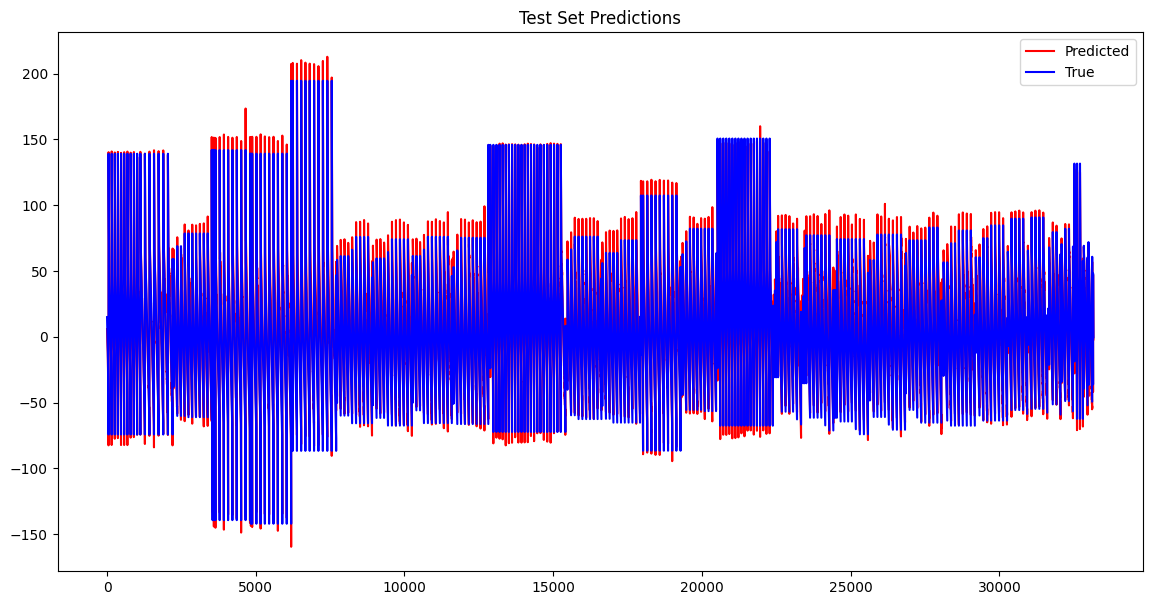

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(predictions, label='Predicted',color = 'red')
plt.plot(y_test, label = "True", color = 'blue')
plt.legend()
plt.title('Test Set Predictions')

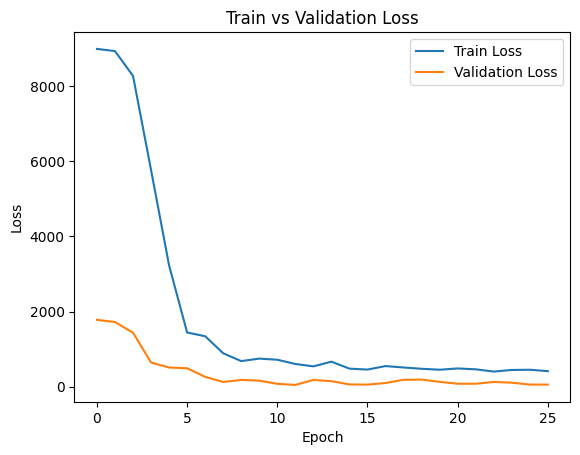

In [28]:
train_loss_list = [8980.82421875, 8923.5087890625, 8262.802734375, 5759.98681640625, 3224.97119140625, 1442.8133544921875, 
                   1343.264404296875, 890.4447021484375, 682.3187866210938, 748.7600708007812, 718.3447265625, 605.8528442382812, 
                   542.348876953125, 666.9859619140625, 481.8097839355469, 457.41162109375, 550.0675048828125, 512.4168701171875, 
                   478.35052490234375, 453.14166259765625, 486.9576721191406, 463.7088623046875, 403.9351806640625, 446.7655029296875, 
                   452.0331726074219, 415.1826171875]
val_loss_list = [1778.7342529296875, 1720.9593505859375, 1437.8150634765625, 644.2469482421875, 511.40386962890625, 
                 491.32757568359375, 263.45794677734375, 128.21737670898438, 181.788330078125, 162.56578063964844, 
                 78.62602996826172, 49.050533294677734, 181.21078491210938, 147.99795532226562, 62.93171310424805, 
                 57.0987663269043, 99.8532485961914, 186.0397186279297, 190.357421875, 131.1597900390625, 80.60486602783203, 
                 80.2590560913086, 127.39952087402344, 108.32402801513672, 58.32400894165039, 57.768531799316406]
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Train vs Validation Loss")
plt.show()
